# Relu
## Problem of Sigmoid
- 뉴럴 네트워크는 input을 받고 output을 출력
- loss: output과 실제 정답 데이터와 얼마나 차이가 나는지 
- loss를 미분한 것을 backpropagation하면서 네트워크를 학습
- gradient: 전달되는 loss를 미분한 것, 그래프의 기울기
- sigmoid에서 가운데 쪽은 기울기 값이 0보다 크고, 극단 좌표계에서는 0에 매우 가까운, 작은 값을 가진다.
- deep한 학습에서 gradient값이 매우 작으면 안됨
- Vanishing Gradient: gradient가 매우 작아 학습시 사라지는 것

## Relu
$$ f(x) = max(0,x) $$

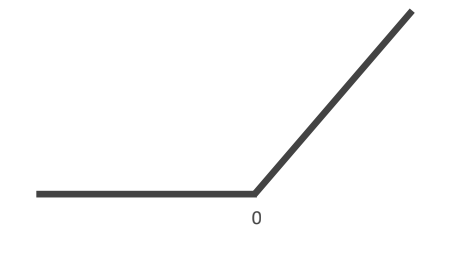
- 어떠한 x를 받았을 때 x가 0보다 큰 양수의 값을 가진다면 x를 output으로 추출하고 0보다 작은 음수의 값을 갖는다면 0으로 바꿔서 추출하는 것
- Relu 함수의 gradient 값은 0보다 큰 값에서 1, 아무리 network가 deep 하더라도 값이 전달됨
- 0보다 작은 값에서 gradient는 0
- tanh, elu, selu 등이 있음 (tf.keras.activations)
- leaky relu: Relo에서 0보다 작을 때의 문제점을 해결한 것 (tf.keras.layers), 어떤 a에 x를 곱한 것을 추출 (a는 매우 작음)

## Import

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from time import time
import os
print(tf.__version__)

2.9.2


# Checkpoint function



In [ ]:
def load(model, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt :
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        checkpoint = tf.train.Checkpoint(dnn=model)
        checkpoint.restore(save_path=os.path.join(checkpoint_dir, ckpt_name))
        counter = int(ckpt_name.split('-')[1])
        print(" [*] Success to read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

def check_folder(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    return dir

## Load mnist&pre-processing


In [ ]:
def load_mnist():
  (train_data, train_labels), (test_data, test_labels) = mnist.load_data()

  # tensorflow가 input으로 받는 요소에는 [batch_size, height, width, channel]이 포함되어야 함
  # 채널을 하나 만들어주는 역할
  # 축 -1은 끝을 의미
  train_data = np.expand_dims(train_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]
  test_data = np.expand_dims(test_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]

  # 이미지 숫자값의 범위를 [0~1]로 바꿔줌
  train_data, test_data = normalize(train_data, test_data)

  # one hot incoding
  train_labels = to_categorical(train_labels, 10) # [N,] -> [N, 10]
  test_labels = to_categorical(test_labels, 10) # [N,] -> [N, 10]

  return train_data, train_labels, test_data, test_labels

def normalize(train_data, test_data):
    train_data = train_data.astype(np.float32) / 255.0
    test_data = test_data.astype(np.float32) / 255.0

    return train_data, test_data

# Create network

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

# unit = output으로 나가는 채널 개수
def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu() :
    return tf.keras.layers.Activation(tf.keras.activations.relu)

## Create model - class

In [ ]:
# tf.keras.Model을 상속해야 함
class create_model_class(tf.keras.Model):
    # label_dim: network의 로직을 구할 때 몇개의 아웃풋을 내야하는지
    def __init__(self, label_dim):
        super(create_model_class, self).__init__()

        # 가우시안 분포
        weight_init = tf.keras.initializers.RandomNormal()

        # Sequential = 리스트 자료구조 타입
        self.model = tf.keras.Sequential()
        self.model.add(flatten()) # [N, 28, 28, 1] -> [N, 784]

        for i in range(2):
            # [N, 784] -> [N, 256] -> [N,256]
            self.model.add(dense(256, weight_init))
            self.model.add(relu())

        self.model.add(dense(label_dim, weight_init)) # [N, 256] -> [N, 10]

    def call(self, x, training=None, mask=None):
        x = self.model(x)

        return x

## Create model - function

In [ ]:
def create_model_function(label_dim) :
    weight_init = tf.keras.initializers.RandomNormal()

    model = tf.keras.Sequential()
    model.add(flatten())

    for i in range(2) :
        model.add(dense(256, weight_init))
        model.add(relu())

    model.add(dense(label_dim, weight_init))

    return model

# Define loss

In [ ]:
def loss_fn(model, images, labels):
    # model에 image를 넣어서 output 추출
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=logits, y_true=labels, 
                                                                   from_logits=True))
    return loss

# 정확도
def accuracy_fn(model, images, labels):
    # model에 images를 넣어서 logit이 뭔지 알아냄
    logits = model(images, training=False)
    # tf.argmax[batch size, label_dim]: 10개의 값들 중에서 가장 큰 값을 가지고 있는 것을 구함
    prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
    # 숫자값으로 바꿔줌
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

# loss를 구했을 때 model weight의 gradient retrurn
def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

# Define data & hyper-parameter

In [ ]:
""" dataset """
train_x, train_y, test_x, test_y = load_mnist()

""" parameters """
learning_rate = 0.001
batch_size = 128

training_epochs = 1
training_iterations = len(train_x) // batch_size

label_dim = 10

train_flag = True

""" Graph Input using Dataset API """
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=batch_size).\
    batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=len(test_x)).\
    batch(len(test_x))

# Define model & optimizer & writer

In [ ]:
""" Model """
network = create_model_function(label_dim)

""" Training """
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

""" Writer """
checkpoint_dir = 'checkpoints'
logs_dir = 'logs'

model_dir = 'nn_relu'

checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
check_folder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
logs_dir = os.path.join(logs_dir, model_dir)

# Restore checkpoint & start train or test phase

In [ ]:
if train_flag :

    checkpoint = tf.train.Checkpoint(dnn=network)

    # create writer for tensorboard
    summary_writer = tf.summary.create_file_writer(logdir=logs_dir)
    start_time = time()

    # restore check-point if it exits
    could_load, checkpoint_counter = load(network, checkpoint_dir)    

    if could_load:
        start_epoch = (int)(checkpoint_counter / training_iterations)        
        counter = checkpoint_counter        
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_iteration = 0
        counter = 0
        print(" [!] Load failed...")
    
    # train phase
    with summary_writer.as_default():  # for tensorboard
        for epoch in range(start_epoch, training_epochs):
            for idx, (train_input, train_label) in enumerate(train_dataset):                
                grads = grad(network, train_input, train_label)
                optimizer.apply_gradients(grads_and_vars=zip(grads, network.variables))

                train_loss = loss_fn(network, train_input, train_label)
                train_accuracy = accuracy_fn(network, train_input, train_label)

                for test_input, test_label in test_dataset:                
                    test_accuracy = accuracy_fn(network, test_input, test_label)

                tf.summary.scalar(name='train_loss', data=train_loss, step=counter)
                tf.summary.scalar(name='train_accuracy', data=train_accuracy, step=counter)
                tf.summary.scalar(name='test_accuracy', data=test_accuracy, step=counter)

                print(
                    "Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                    % (epoch, idx, training_iterations, time() - start_time, train_loss, train_accuracy,
                       test_accuracy))
                counter += 1
        checkpoint.save(file_prefix=checkpoint_prefix + '-{}'.format(counter))
        
# test phase      
else :
    _, _ = load(network, checkpoint_dir)
    for test_input, test_label in test_dataset:    
        test_accuracy = accuracy_fn(network, test_input, test_label)

    print("test_Accuracy: %.4f" % (test_accuracy))

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load failed...
Epoch: [ 0] [    0/  468] time: 1.1970, train_loss: 2.18015814, train_accuracy: 0.3594, test_Accuracy: 0.2053
Epoch: [ 0] [    1/  468] time: 1.4015, train_loss: 2.13980103, train_accuracy: 0.4922, test_Accuracy: 0.4097
Epoch: [ 0] [    2/  468] time: 1.5871, train_loss: 2.06436300, train_accuracy: 0.4375, test_Accuracy: 0.4842
Epoch: [ 0] [    3/  468] time: 1.7775, train_loss: 2.00024700, train_accuracy: 0.5859, test_Accuracy: 0.5827
Epoch: [ 0] [    4/  468] time: 1.9784, train_loss: 1.92871141, train_accuracy: 0.6641, test_Accuracy: 0.6325
Epoch: [ 0] [    5/  468] time: 2.1926, train_loss: 1.84263396, train_accuracy: 0.6406, test_Accuracy: 0.6593
Epoch: [ 0] [    6/  468] time: 2.3935, train_loss: 1.71736670, train_accuracy: 0.7656, test_Accuracy: 0.6719
Epoch: [ 0] [    7/  468] time: 2.5944, train_loss: 1.63354254, train_accuracy: 0.7188, test_Accuracy: 0.6782
Epoch: [ 0] [    8/  468] time: 2.9290,

# weight Initialization

## Xavier Initialization (Glorot Initialization)
- 우리의 네트워크는 loss가 가장 최저인 지점을 찾아내는 것이 목표 
- loss 그래프가 복잡할 때 시작점을 잘못 잡으면 local minima에 빠질 수 있고, saddle posint에 도달 할 수도 있음
- weight 초기화는 어디서부터 출발할 지 설정해 주는것
- Xavier의 평균은 0
- Variance
$$ \frac{2}{channel\_in+channel\_out} $$

## He Initialization
- He Initialization은 Relu 함수에 특화된 Initialization 방법
  - 평균 0
  - variance
  $$ \frac{4}{channel\_in+channel\_out} $$

# Import


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
from time import time
import os
print(tf.__version__)

2.9.2


# Checkpoint function

In [ ]:
def load(model, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt :
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        checkpoint = tf.train.Checkpoint(dnn=model)
        checkpoint.restore(save_path=os.path.join(checkpoint_dir, ckpt_name))
        counter = int(ckpt_name.split('-')[1])
        print(" [*] Success to read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

def check_folder(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    return dir

# Load mnist

In [ ]:
def load_mnist() :
    (train_data, train_labels), (test_data, test_labels) = mnist.load_data()
    train_data = np.expand_dims(train_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]
    test_data = np.expand_dims(test_data, axis=-1) # [N, 28, 28] -> [N, 28, 28, 1]

    train_data, test_data = normalize(train_data, test_data)

    train_labels = to_categorical(train_labels, 10) # [N,] -> [N, 10]
    test_labels = to_categorical(test_labels, 10) # [N,] -> [N, 10]

    return train_data, train_labels, test_data, test_labels

def normalize(train_data, test_data):
    train_data = train_data.astype(np.float32) / 255.0
    test_data = test_data.astype(np.float32) / 255.0

    return train_data, test_data

# Performance function

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=logits, y_true=labels, 
                                                                   from_logits=True))
    return loss

def accuracy_fn(model, images, labels):
    logits = model(images, training=False)
    prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

# Create network

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu() :
    return tf.keras.layers.Activation(tf.keras.activations.relu)

# Create model - class

In [ ]:
class create_model_class(tf.keras.Model):
    def __init__(self, label_dim):
        super(create_model_class, self).__init__()
        # or tf.keras.initializers.he_uniform()
        weight_init = tf.keras.initializers.glorot_uniform()

        self.model = tf.keras.Sequential()
        self.model.add(flatten())

        for i in range(2):
            self.model.add(dense(256, weight_init))
            self.model.add(relu())

        self.model.add(dense(label_dim, weight_init))

    def call(self, x, training=None, mask=None):

        x = self.model(x)

        return x

# Create model - function

In [ ]:
def create_model_function(label_dim) :
   # or tf.keras.initializers.he_uniform()
    weight_init = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()
    model.add(flatten())

    for i in range(2) :
        model.add(dense(256, weight_init))
        model.add(relu())

    model.add(dense(label_dim, weight_init))

    return model

# Define data & hyper-parameter

In [ ]:
""" dataset """
train_x, train_y, test_x, test_y = load_mnist()

""" parameters """
learning_rate = 0.001
batch_size = 128

training_epochs = 1
training_iterations = len(train_x) // batch_size

label_dim = 10

train_flag = True

""" Graph Input using Dataset API """
train_dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=batch_size).\
    batch(batch_size, drop_remainder=True)

test_dataset = tf.data.Dataset.from_tensor_slices((test_x, test_y)).\
    shuffle(buffer_size=100000).\
    prefetch(buffer_size=len(test_x)).\
    batch(len(test_x))

# Define model & optimizer & writer

In [ ]:
""" Model """
network = create_model_function(label_dim)

""" Training """
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

""" Writer """
checkpoint_dir = 'checkpoints'
logs_dir = 'logs'

model_dir = 'nn_xavier'

checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
check_folder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
logs_dir = os.path.join(logs_dir, model_dir)

# Restore checkpoint & start train or test phase

In [ ]:
if train_flag :

    checkpoint = tf.train.Checkpoint(dnn=network)

    # create writer for tensorboard
    summary_writer = tf.summary.create_file_writer(logdir=logs_dir)
    start_time = time()

    # restore check-point if it exits
    could_load, checkpoint_counter = load(network, checkpoint_dir)    

    if could_load:
        start_epoch = (int)(checkpoint_counter / training_iterations)        
        counter = checkpoint_counter        
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_iteration = 0
        counter = 0
        print(" [!] Load failed...")
    
    # train phase
    with summary_writer.as_default():  # for tensorboard
        for epoch in range(start_epoch, training_epochs):
            for idx, (train_input, train_label) in enumerate(train_dataset):                
                grads = grad(network, train_input, train_label)
                optimizer.apply_gradients(grads_and_vars=zip(grads, network.variables))

                train_loss = loss_fn(network, train_input, train_label)
                train_accuracy = accuracy_fn(network, train_input, train_label)

                for test_input, test_label in test_dataset:                
                    test_accuracy = accuracy_fn(network, test_input, test_label)

                tf.summary.scalar(name='train_loss', data=train_loss, step=counter)
                tf.summary.scalar(name='train_accuracy', data=train_accuracy, step=counter)
                tf.summary.scalar(name='test_accuracy', data=test_accuracy, step=counter)

                print(
                    "Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                    % (epoch, idx, training_iterations, time() - start_time, train_loss, train_accuracy,
                       test_accuracy))
                counter += 1
        checkpoint.save(file_prefix=checkpoint_prefix + '-{}'.format(counter))
        
# test phase      
else :
    _, _ = load(network, checkpoint_dir)
    for test_input, test_label in test_dataset:    
        test_accuracy = accuracy_fn(network, test_input, test_label)

    print("test_Accuracy: %.4f" % (test_accuracy))

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load failed...
Epoch: [ 0] [    0/  468] time: 0.5183, train_loss: 2.02894783, train_accuracy: 0.3359, test_Accuracy: 0.1907
Epoch: [ 0] [    1/  468] time: 0.7132, train_loss: 1.96024799, train_accuracy: 0.4375, test_Accuracy: 0.3670
Epoch: [ 0] [    2/  468] time: 1.0506, train_loss: 1.85483813, train_accuracy: 0.5391, test_Accuracy: 0.5061
Epoch: [ 0] [    3/  468] time: 1.7360, train_loss: 1.79507709, train_accuracy: 0.5703, test_Accuracy: 0.6344
Epoch: [ 0] [    4/  468] time: 2.4237, train_loss: 1.70726573, train_accuracy: 0.7109, test_Accuracy: 0.7043
Epoch: [ 0] [    5/  468] time: 3.1785, train_loss: 1.50102746, train_accuracy: 0.7188, test_Accuracy: 0.7366
Epoch: [ 0] [    6/  468] time: 3.5981, train_loss: 1.35314465, train_accuracy: 0.7422, test_Accuracy: 0.7435
Epoch: [ 0] [    7/  468] time: 4.1011, train_loss: 1.20339775, train_accuracy: 0.7656, test_Accuracy: 0.7501
Epoch: [ 0] [    8/  468] time: 4.3701,

# Dropout
- training data set의 샘플이 분포되어 있음
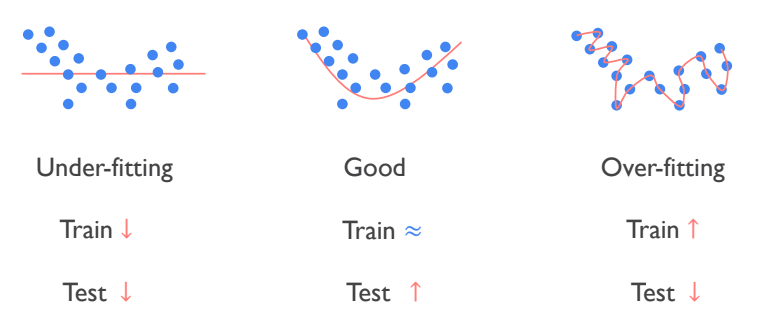
  - Under-fittin: Traning Data의 sample들의 정확도가 낮고, Test Data set의 정확도도 낮음
  - Over-fitting: Traning Data의 sample들의 정확도가 높은 것, Test Data set의 정확도는 낮음
- Network가 있을 때, 각각의 뉴런들 중 몇 개를 끄고 학습하는 것, 즉, 일부분만 활용하는 것
  - 무슨 노드를 끄는지는 랜덤
  - Test 때는 모든 뉴런들을 이용
- Regularization이라고 할 수 있음

# Create network

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu() :
    return tf.keras.layers.Activation(tf.keras.activations.relu)

def dropout(rate) :
    return tf.keras.layers.Dropout(rate)

# Performance function

In [ ]:
def loss_fn(model, images, labels):
    logits = model(images, training=True)
    loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_pred=logits, y_true=labels, 
                                                                   from_logits=True))
    return loss

def accuracy_fn(model, images, labels):
    logits = model(images, training=False)
    prediction = tf.equal(tf.argmax(logits, -1), tf.argmax(labels, -1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    return accuracy

def grad(model, images, labels):
    with tf.GradientTape() as tape:
        loss = loss_fn(model, images, labels)
    return tape.gradient(loss, model.variables)

# Create model - function

In [ ]:
class create_model_class(tf.keras.Model):
    def __init__(self, label_dim):
        super(create_model_class, self).__init__()
        weight_init = tf.keras.initializers.glorot_uniform()

        self.model = tf.keras.Sequential()
        self.model.add(flatten())

        for i in range(4):
            self.model.add(dense(512, weight_init))
            self.model.add(relu())
            self.model.add(dropout(rate=0.5))

        self.model.add(dense(label_dim, weight_init))

    def call(self, x, training=None, mask=None):

        x = self.model(x)

        return x

# Create network - function

In [ ]:
def create_model_function(label_dim) :
    weight_init = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()
    model.add(flatten())

    for i in range(4) :
        model.add(dense(512, weight_init))
        model.add(relu())
        model.add(dropout(rate=0.5))

    model.add(dense(label_dim, weight_init))

    return model

# Define model & optimizer & writer

In [ ]:
""" Model """
network = create_model_function(label_dim)

""" Training """
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

""" Writer """
checkpoint_dir = 'checkpoints'
logs_dir = 'logs'

model_dir = 'nn_dropout'

checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
check_folder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
logs_dir = os.path.join(logs_dir, model_dir)

# Restore checkpoint & start train or test phase

In [ ]:
if train_flag :

    checkpoint = tf.train.Checkpoint(dnn=network)

    # create writer for tensorboard
    summary_writer = tf.summary.create_file_writer(logdir=logs_dir)
    start_time = time()

    # restore check-point if it exits
    could_load, checkpoint_counter = load(network, checkpoint_dir)    

    if could_load:
        start_epoch = (int)(checkpoint_counter / training_iterations)        
        counter = checkpoint_counter        
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_iteration = 0
        counter = 0
        print(" [!] Load failed...")
    
    # train phase
    with summary_writer.as_default():  # for tensorboard
        for epoch in range(start_epoch, training_epochs):
            for idx, (train_input, train_label) in enumerate(train_dataset):            
                grads = grad(network, train_input, train_label)
                optimizer.apply_gradients(grads_and_vars=zip(grads, network.variables))

                train_loss = loss_fn(network, train_input, train_label)
                train_accuracy = accuracy_fn(network, train_input, train_label)
                
                for test_input, test_label in test_dataset:                
                    test_accuracy = accuracy_fn(network, test_input, test_label)

                tf.summary.scalar(name='train_loss', data=train_loss, step=counter)
                tf.summary.scalar(name='train_accuracy', data=train_accuracy, step=counter)
                tf.summary.scalar(name='test_accuracy', data=test_accuracy, step=counter)

                print(
                    "Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                    % (epoch, idx, training_iterations, time() - start_time, train_loss, train_accuracy,
                       test_accuracy))
                counter += 1                
        checkpoint.save(file_prefix=checkpoint_prefix + '-{}'.format(counter))
        
# test phase      
else :
    _, _ = load(network, checkpoint_dir)
    for test_input, test_label in test_dataset:    
        test_accuracy = accuracy_fn(network, test_input, test_label)

    print("test_Accuracy: %.4f" % (test_accuracy))

 [*] Reading checkpoints...
 [*] Failed to find a checkpoint
 [!] Load failed...
Epoch: [ 0] [    0/  468] time: 0.8293, train_loss: 2.32374096, train_accuracy: 0.2734, test_Accuracy: 0.1889
Epoch: [ 0] [    1/  468] time: 1.5295, train_loss: 2.28977537, train_accuracy: 0.1875, test_Accuracy: 0.1310
Epoch: [ 0] [    2/  468] time: 2.2412, train_loss: 2.25335622, train_accuracy: 0.1641, test_Accuracy: 0.1086
Epoch: [ 0] [    3/  468] time: 2.9394, train_loss: 2.22751999, train_accuracy: 0.1016, test_Accuracy: 0.1382
Epoch: [ 0] [    4/  468] time: 3.6477, train_loss: 2.25236654, train_accuracy: 0.1797, test_Accuracy: 0.1820
Epoch: [ 0] [    5/  468] time: 4.1752, train_loss: 2.23017287, train_accuracy: 0.3281, test_Accuracy: 0.3211
Epoch: [ 0] [    6/  468] time: 4.8742, train_loss: 2.18742990, train_accuracy: 0.4297, test_Accuracy: 0.4438
Epoch: [ 0] [    7/  468] time: 5.5828, train_loss: 2.19688082, train_accuracy: 0.4531, test_Accuracy: 0.4486
Epoch: [ 0] [    8/  468] time: 6.2895,

# Batch Normalization
- network가 있을 때, input으로 들어온 데이터의 분포는 뉴런을 지날수록 변형됨 -> 학습이 덜 됨, Internal Covariate Shift
- $$ \bar x = \frac{x-\mu_B}{\sqrt {\sigma_B^2} + \epsilon } $$
- $$ \hat x = y\bar x + \beta $$

# Checkpoint function

In [ ]:
def load(model, checkpoint_dir):
    print(" [*] Reading checkpoints...")

    ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
    if ckpt :
        ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
        checkpoint = tf.train.Checkpoint(dnn=model)
        checkpoint.restore(save_path=os.path.join(checkpoint_dir, ckpt_name))
        counter = int(ckpt_name.split('-')[1])
        print(" [*] Success to read {}".format(ckpt_name))
        return True, counter
    else:
        print(" [*] Failed to find a checkpoint")
        return False, 0

def check_folder(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
    return dir

# Create network

In [ ]:
def flatten() :
    return tf.keras.layers.Flatten()

def dense(label_dim, weight_init) :
    return tf.keras.layers.Dense(units=label_dim, use_bias=True, kernel_initializer=weight_init)

def relu() :
    return tf.keras.layers.Activation(tf.keras.activations.relu)

def batch_norm() :
    return tf.keras.layers.BatchNormalization()

# Create model - class

In [ ]:
class create_model_class(tf.keras.Model):
    def __init__(self, label_dim):
        super(create_model_class, self).__init__()
        weight_init = tf.keras.initializers.glorot_uniform()

        self.model = tf.keras.Sequential()
        self.model.add(flatten())
        
        # 순서는 layer - norm - activation or norm - activation - layer
        for i in range(4):
            self.model.add(dense(512, weight_init))
            self.model.add(batch_norm())
            self.model.add(relu())

        self.model.add(dense(label_dim, weight_init))

    def call(self, x, training=None, mask=None):

        x = self.model(x)

        return x

# Create model - function

In [ ]:
def create_model_function(label_dim) :
    weight_init = tf.keras.initializers.glorot_uniform()

    model = tf.keras.Sequential()
    model.add(flatten())

    for i in range(4) :
        model.add(dense(512, weight_init))
        model.add(batch_norm())
        model.add(relu())

    model.add(dense(label_dim, weight_init))

    return model

# Define model & optimizer & writer

In [ ]:
""" Model """
network = create_model_function(label_dim)

""" Training """
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

""" Writer """
checkpoint_dir = 'checkpoints'
logs_dir = 'logs'

model_dir = 'nn_dropout'

checkpoint_dir = os.path.join(checkpoint_dir, model_dir)
check_folder(checkpoint_dir)
checkpoint_prefix = os.path.join(checkpoint_dir, model_dir)
logs_dir = os.path.join(logs_dir, model_dir)

# Restore checkpoint & start train or test phase

In [ ]:
if train_flag :

    checkpoint = tf.train.Checkpoint(dnn=network)

    # create writer for tensorboard
    summary_writer = tf.summary.create_file_writer(logdir=logs_dir)
    start_time = time()

    # restore check-point if it exits
    could_load, checkpoint_counter = load(network, checkpoint_dir)    

    if could_load:
        start_epoch = (int)(checkpoint_counter / training_iterations)        
        counter = checkpoint_counter        
        print(" [*] Load SUCCESS")
    else:
        start_epoch = 0
        start_iteration = 0
        counter = 0
        print(" [!] Load failed...")
    
    # train phase
    with summary_writer.as_default():  # for tensorboard
        for epoch in range(start_epoch, training_epochs):
            for idx, (train_input, train_label) in enumerate(train_dataset):            
                grads = grad(network, train_input, train_label)
                optimizer.apply_gradients(grads_and_vars=zip(grads, network.trainable_variables))

                train_loss = loss_fn(network, train_input, train_label)
                train_accuracy = accuracy_fn(network, train_input, train_label)
                
                for test_input, test_label in test_dataset:                
                    test_accuracy = accuracy_fn(network, test_input, test_label)

                tf.summary.scalar(name='train_loss', data=train_loss, step=counter)
                tf.summary.scalar(name='train_accuracy', data=train_accuracy, step=counter)
                tf.summary.scalar(name='test_accuracy', data=test_accuracy, step=counter)

                print(
                    "Epoch: [%2d] [%5d/%5d] time: %4.4f, train_loss: %.8f, train_accuracy: %.4f, test_Accuracy: %.4f" \
                    % (epoch, idx, training_iterations, time() - start_time, train_loss, train_accuracy,
                       test_accuracy))
                counter += 1                
        checkpoint.save(file_prefix=checkpoint_prefix + '-{}'.format(counter))
        
# test phase      
else :
    _, _ = load(network, checkpoint_dir)
    for test_input, test_label in test_dataset:    
        test_accuracy = accuracy_fn(network, test_input, test_label)

    print("test_Accuracy: %.4f" % (test_accuracy))

 [*] Reading checkpoints...
 [*] Success to read nn_dropout-468-1
 [*] Load SUCCESS


# ConvNet의 Conv 레이어 만들기
## history
- 고양이 실험에서 시작
- 고양이는 각각 뉴런이 이미지의 어떤 형태의 부분에서만 반응함

## 방법
- 이미지를 잘라서 Conv에 넣음
- Relu 함수 층을 넣음
- 여러번 할 수 있음
- 중간에 한 번씩 Polling을 함
- 마지막으로 FC를 붙임

## Start with an image (width * hight * depth)
- filter를 이용하여 이미지를 부분적으로 처리
- depth는 원본과 filter가 같아야 함
- filter는 값 하나를 만들어 냄
  - $$ Wx + b = ReLU(Wx+b)$$
- filter를 이동시키면서 전체 이미지를 처리
- 몇 개의 number가 나올까?
  - output size: (N-F) / stride + 1
- 움직이는 간격을 stride라고 부름

## padding
- 테두리에 가상의 입력을 만들어 주는 것
- 그림이 작아지는 것을 방지하기 위해
- 모서리임을 알려주기 위해
- 입력의 이미지와 출력의 이미지가 같아지기 위해 사용

## Convolution layer
- Convolution layer를 사용하면 깊이가 깊어짐


# ConvNet Max pooling과 Full Network
## Pooling
- sampling이라고 봄
- convolution layer에서 한 레이어만 뽑아내서 resize함
- 각각의 한 레이어씩 반복

## Max Pooling
- poll filter가 2X3고 stride가 2이면
  - 4개의 필터가 생김
  - 2X2의 output
  - 한 필터에 있는 값 중에서 가장 큰 값을 고르는 것
- 전체의 값들 중에 하나만 뽑아서 sampling이라고도 부름

## Fully Connected Layer


# Conv net의 활용 예
## LeNet-5
- input이 주어지고 각각의 convolution에 5*5, stride 1을 사용

## AlexNet
- Image net 경진대회에서 1등
- color image를 입력받음
- 첫번째 레이어에서 96개의 필터 사용, stride 4
- 두번째 레이어에서 3*3 필터, stride 2
- 계속해서 이어짐
- Nomalization layer: 값들을 Nomalition 하는 것, 최근 들어서는 잘 사용되지 않음
- ReLU를 처음 사용

## GoogLeNet
- 2014의 1등
- Inception module: 입력이 들어가고 1X1 convolution, 3X3 pooling을 함
- Inception module을 deep하게 연결

## ResNet
- 152개 layer 사용
- layer가 깊어지면 학습이 어려움
  - 중간의 값을 jump 시키는 Residual net을 사용
  - 실제 학습할때는 깊지 않은 것처럼 학습할 수 있음

